In [1]:
import os
import time
import argparse
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from einops import rearrange, repeat


from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test
from data_prepare import choose_all_pixels, all_data
from data_prepare import train_and_test_data, train_and_test_label


from CNNUtils import train, test, valid
from Utils import output_metric, plot_confusion_matrix
from Utils import list_to_colormap, classification_map, print_args


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("HSI")
parser.add_argument('--dataset', choices=['LongKou', 'HanChuan', 'HongHu', 'Pavia'], default='Pavia', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--seed', type=int, default=42, help='number of seed')
parser.add_argument('--batch_size', type=int, default=30, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=15, help='size of patches')
parser.add_argument('--band_patches', type=int, default=1, help='number of related band')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0, help='weight_decay')
parser.add_argument('--train_number', type=int, default=25, help='num_train_per_class')
args = parser.parse_args(args=[])

In [3]:
# prepare data
data_path = os.path.join(os.getcwd(), 'dataset')

if args.dataset == 'LongKou':
    data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou.mat'))['WHU_Hi_LongKou']
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_LongKou_gt.mat'))['WHU_Hi_LongKou_gt']
elif args.dataset == 'Pavia':
    data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
    label = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 9


In [4]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [5]:
def applyPCA(data, numComponents=30):
    new_data = np.reshape(data, (-1, data.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    new_data = pca.fit_transform(new_data)
    new_data = np.reshape(new_data, (data.shape[0], data.shape[1], numComponents))
    return new_data, pca

In [6]:
K = 30
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=610, width=340, band=30


In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

*******************************************************
patch_size : 15
mirror_data shape : [624, 354, 30]
*******************************************************


In [8]:
total_pos_train, total_pos_test, total_pos_valid, number_train, number_test, number_valid = choose_train_and_test(label, args.train_number, args.seed) 

x_train, x_test, x_valid = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, total_pos_valid, args.patch_size)
y_train, y_test, y_valid = train_and_test_label(number_train, number_test, number_valid, num_classes)

*******************************************************
x_train shape = (225, 15, 15, 30), type = float64
x_test  shape = (42551, 15, 15, 30), type = float64
x_valid  shape = (900, 15, 15, 30), type = float64
*******************************************************
y_train: shape = (225,), type = int64
y_test: shape = (42551,), type = int64
y_valid: shape = (900,), type = int64
*******************************************************


In [9]:
total_pos_train[:10]

array([[409, 293],
       [404, 298],
       [380, 301],
       [551,  14],
       [453, 165],
       [140, 172],
       [471, 169],
       [175, 187],
       [482, 185],
       [214, 200]])

In [10]:
# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (90, 30, 15, 15)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
train_label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 30, 15, 15)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
test_label = Data.TensorDataset(x_test, y_test)

x_valid = torch.from_numpy(x_valid.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 30, 15, 15)
print(x_valid.shape)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)
valid_label = Data.TensorDataset(x_valid, y_valid)

train_loader = Data.DataLoader(train_label, batch_size=30, shuffle=True)
test_loader = Data.DataLoader(test_label, batch_size=128, shuffle=True)
valid_loader = Data.DataLoader(valid_label, batch_size=64, shuffle=True)

torch.Size([225, 30, 15, 15])
torch.Size([42551, 30, 15, 15])
torch.Size([900, 30, 15, 15])


## Create Model

In [11]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)  # 在特征维度进行归一化
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim), 
            nn.GELU(), 
            nn.Dropout(dropout), 
            nn.Linear(hidden_dim, dim), 
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [12]:
class Attention(nn.Module):
    def __init__(self, dim, heads, dim_head, dropout):
        super().__init__()
        inner_dim = dim_head * heads  # 64  多头注意力级联之后的维度，这里有4头注意力
        self.heads = heads  # 4
        self.scale = dim_head ** -0.5  # 16 ** (-0.5) = 0.25
        
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)  # (batch, 201, 64 * 3)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),   # 恢复到原始嵌入特征的维度
            nn.Dropout(dropout)
        )
    def forward(self, x):
        # x: (batch, 201, 64)
        b, n, _, h = *x.shape, self.heads  # batch, 201, 64, 4
        
        # get qkv tuple: ((batch, 201, 64), (...), (...))
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)  # q, k, v : (batch, 4, 201, 16)
        
        # transpose(k) * q / sqrt(dim_head) -> (batch, head_num, 201, 201)
        dots = torch.einsum('bhid, bhjd->bhij', q, k) * self.scale  # batch matrix multiplication :(batch, 4, 201, 201)
        mask_value = -torch.finfo(dots.dtype).max
            
        # softmax normalization -> attention matrix
        attn = dots.softmax(dim=-1)  # (batch, 4, 201, 201)
        # attn * attention matrix -> output
        out = torch.einsum('bhij, bhjd -> bhid', attn, v)  # (batch, 4, 201, 16)
        # cat all output -> (batch, 201, dim_head * heads)
        out = rearrange(out, 'b h n d -> b n (h d)')  # (batch, 201, 64)
        out = self.to_out(out)  # 恢复到原始嵌入特征的维度以进行残差学习
        return out

In [13]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout, num_channel):
        super().__init__()
        
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim, dropout=dropout)))
            ]))
        self.skipcat = nn.ModuleList([])
        for _ in range(depth-2):
            self.skipcat.append(nn.Conv2d(num_channel+1, num_channel+1, [1, 2], 1, 0))
            
    def forward(self, x):
        # x: (batch, 201, 64)
        last_output = []
        nl = 0
        for attn, ff in self.layers:
            last_output.append(x)
            if nl > 1:
                x = self.skipcat[nl-2](torch.cat([x.unsqueeze(3), last_output[nl-2].unsqueeze(3)], dim=3)).squeeze(3)
            x = attn(x)
            x = ff(x)
            nl += 1
        return x

In [14]:
class ViT(nn.Module):
    """
    dim: 嵌入特征维数 64
    depth: Transformer中编码器的层数(个数) 5
    heads: 多头注意力机制里面的头数 4 
    mlp_dim: Transformer编码器中MLP层的中间隐藏层的维数 8
    dim_head: 注意力的维度
    """
    def __init__(self, img_size=15, in_chans=30, out_chans=64, dim=64, depth=5, heads=4, mlp_dim=16, 
                 dim_head=16, dropout=0.1, emb_dropout=0.1, num_classes=9):
        super(ViT, self).__init__()
        
        self.conv = nn.Sequential(nn.Conv2d(in_chans, out_chans, 3), nn.BatchNorm2d(64), nn.ReLU())
        
        self.pos_embedding = nn.Parameter(torch.randn(1, 64 + 1, dim))  # (1, 201, dim)，dim表示嵌入特征维度
        self.patch_to_embedding = nn.Linear((img_size - 2) ** 2, dim)  # (batch, 200, 64)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))  # (1, 1, 64)
        
        self.dropout = nn.Dropout(emb_dropout)
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout, out_chans)
        
        self.to_latent = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim), 
            nn.Linear(dim, num_classes)
        )
        
    def forward(self, x):
        # x: (batch, patch_num, patch*patch*near_band) (batch, 200, 75)
        x = self.conv(x)  # (B, 64, 13, 13)
        x = rearrange(x, 'b c h w -> b c (h w)')  # (B, 64, 169) 
        
        x = self.patch_to_embedding(x)  # (batch, 200, 64)
        b, n, _ = x.shape
        
        # add position embedding
        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b=b)  # (batch, 1, 64(dim))
        x = torch.cat((cls_tokens, x), dim=1)  # (batch, 201, 64)
        x += self.pos_embedding # (batch, 201, 64)
        x = self.dropout(x)
        
        # transformer: x: (batch, 201, 64(dim)) -> (batch, 201, 64(dim))
        x = self.transformer(x)
        
        # classification: using cls_token output
        x = self.to_latent(x[:, 0])  # x[:, 0]: (batch, 64)
        
        # MLP classification layer
        return self.mlp_head(x)

In [15]:
model = ViT(num_classes=num_classes, dim=64, depth=5, heads=4, mlp_dim=16, dropout=0.1, emb_dropout= 0.1)

In [16]:
model = model.cuda()
# criterion
criterion = nn.CrossEntropyLoss().cuda()
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)

## Valid

In [17]:
print('start training')
acc_list = [0.00]
path = './model/SpectralFormer.pt'
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(model, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(model, valid_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to SSFTTnet.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(model.state_dict(), path)
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]

toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

start training
Epoch: 001 - train_loss: 2.2485 - train_acc: 13.7778 - valid_loss: 2.0144 - valid_acc: 26.5556
val_acc improved from 0.0000 to 26.5556, saving model to SSFTTnet.pt
Epoch: 002 - train_loss: 1.8943 - train_acc: 28.4444 - valid_loss: 1.7446 - valid_acc: 35.3333
val_acc improved from 26.5556 to 35.3333, saving model to SSFTTnet.pt
Epoch: 003 - train_loss: 1.5942 - train_acc: 44.4444 - valid_loss: 1.5196 - valid_acc: 50.2222
val_acc improved from 35.3333 to 50.2222, saving model to SSFTTnet.pt
Epoch: 004 - train_loss: 1.3922 - train_acc: 60.8889 - valid_loss: 1.3832 - valid_acc: 54.7778
val_acc improved from 50.2222 to 54.7778, saving model to SSFTTnet.pt
Epoch: 005 - train_loss: 1.1633 - train_acc: 70.6667 - valid_loss: 1.1147 - valid_acc: 69.7778
val_acc improved from 54.7778 to 69.7778, saving model to SSFTTnet.pt
Epoch: 006 - train_loss: 0.8546 - train_acc: 78.2222 - valid_loss: 0.9275 - valid_acc: 72.6667
val_acc improved from 69.7778 to 72.6667, saving model to SSFTTnet

In [18]:
model.load_state_dict(torch.load(path))
model.eval()

tar_test, pre_test = test(model, test_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [19]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")
print("Parameter:")
print_args(vars(args))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 89.40, AA: 90.03, Kappa: 0.8612
*******************************************************************
Recal: [ 77.35  93.94  80.81  95.69 100.    94.72  99.92  70.93  96.85]
*******************************************************************
Parameter:
dataset: Pavia
flag_test: train
seed: 42
batch_size: 30
patch_size: 15
band_patches: 1
epoches: 100
learning_rate: 0.001
gamma: 0.99
weight_decay: 0
train_number: 25
*******************************************************************


In [ ]:
average_accuracy = str(list(AA_test))
file_name = "./CR/specfor_1.txt"

with open(file_name, 'w') as x_file:
    x_file.write("[{:.2f}, {:.2f}, {:.4f}]".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))

## Panoramic Classification

In [20]:
def output_label(model, loader):
    model.eval()
    pre = np.array([]).astype('int')
    with torch.no_grad():
        for batch_idx, (batch_data, batch_target) in enumerate(loader):
            batch_data = batch_data.cuda()
            batch_pred = model(batch_data)  # (B, 9)
            _, pred = batch_pred.topk(1, axis=1)  # (B, 1)
            pp = pred.squeeze()
            pre = np.append(pre, pp.data.cpu().numpy())
    return pre

In [21]:
pos_forward, pos_backward = choose_all_pixels(label)

x_forward, x_backward, y_forward, y_backward = all_data(mirror_data, band, pos_forward, pos_backward, patch_size=args.patch_size)

*******************************************************
x_forward shape = (42776, 15, 15, 30), type = float64
x_backward  shape = (164624, 15, 15, 30), type = float64
*******************************************************


In [22]:
# load data
x_forward = torch.from_numpy(x_forward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_forward.shape)
y_forward = torch.from_numpy(y_forward).type(torch.LongTensor)  # (13,)
forward_label = Data.TensorDataset(x_forward, y_forward)

x_backward = torch.from_numpy(x_backward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_backward.shape)
y_backward = torch.from_numpy(y_backward).type(torch.LongTensor)  # (13,)
backward_label = Data.TensorDataset(x_backward, y_backward)

forward_loader = Data.DataLoader(forward_label, batch_size=128, shuffle=False)
backward_loader = Data.DataLoader(backward_label, batch_size=128, shuffle=False)

torch.Size([42776, 30, 15, 15])
torch.Size([164624, 30, 15, 15])


In [23]:
# output classification maps
pre_forward = output_label(model, forward_loader)
pre_backward = output_label(model, backward_loader)

prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(pos_forward.shape[0]):
    prediction_matrix[pos_forward[i, 0], pos_forward[i, 1]] = pre_forward[i] + 1

for j in range(pos_backward.shape[0]):
    prediction_matrix[pos_backward[j, 0], pos_backward[j, 1]] = pre_backward[j] + 1

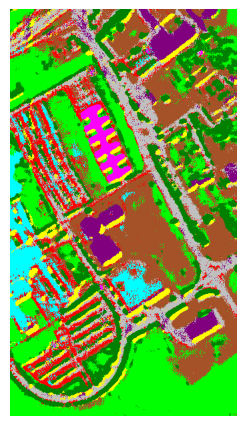

In [24]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

classification_map(predict_map, './pavia_specfor.pdf')